<h2>   
      <font color = blue >
            <span style='font-family:Georgia'>
            Enhanced Product Search for Flipkart
            </span>   
        </font>    
</h2>

<h3 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Importing Necessary Libraries
            </span>   
        </font>    
</h3>

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from nrclex import NRCLex
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import pickle
import tkinter as tk

import warnings
warnings.filterwarnings('ignore')

<h3 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Loading the Dataset
            </span>   
        </font>    
</h3>

In [2]:
flipkart_df = pd.read_csv("clean_flipkart_product.csv", header=0, encoding='ISO-8859-1')

<h3 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Data Cleaning and Pre-processing
            </span>   
        </font>    
</h3>

In [3]:
# Remove '?ÿ?ÿ' and text within parentheses in the 'ProductName' column
flipkart_df['ProductName'] = flipkart_df['ProductName'].str.replace(r'\?ÿ\?ÿ|\(.*\)', '', regex=True)

# Convert the 'Price' column to strings
flipkart_df['Price'] = flipkart_df['Price'].astype(str)

# Remove symbols and keep only numbers
flipkart_df['Price'] = flipkart_df['Price'].apply(lambda x: re.sub('[^\d]', '', x))

# Convert the 'price' column to numeric (int or float)
flipkart_df['Price'] = pd.to_numeric(flipkart_df['Price'])

flipkart_df = flipkart_df.dropna(subset=['Rate'])
flipkart_df['Rate'] = pd.to_numeric(flipkart_df['Rate'], errors='coerce')
flipkart_df['Rate'].fillna(0, inplace=True)

flipkart_df = flipkart_df.drop_duplicates(subset=['UserID', 'ProductName'])

flipkart_df

UserID                                        ProductName  \
0       FLP20IND2522               Candes 12 L Room/Personal Air Cooler   
1       FLP20IND2689               Candes 12 L Room/Personal Air Cooler   
2       FLP20IND2281               Candes 12 L Room/Personal Air Cooler   
3       FLP20IND2500               Candes 12 L Room/Personal Air Cooler   
4       FLP20IND2013               Candes 12 L Room/Personal Air Cooler   
...              ...                                                ...   
124294  FLP20IND2909  NIVEA Soft Light Moisturizer for Face, Hand & ...   
124295  FLP20IND2897  NIVEA Soft Light Moisturizer for Face, Hand & ...   
124296  FLP20IND2500  NIVEA Soft Light Moisturizer for Face, Hand & ...   
124297  FLP20IND2086  NIVEA Soft Light Moisturizer for Face, Hand & ...   
124298  FLP20IND1959  NIVEA Soft Light Moisturizer for Face, Hand & ...   

        Price  Rate               Review  \
0        3999   5.0               Super!   
1        3999   5.0              Awesome   
2        3999   3.0                 Fair   
3        3999   1.0      Useless product   
4        3999   3.0                 Fair   
...       ...   ...                  ...   
124294    142   5.0     Perfect product!   
124295    142   5.0              Awesome   
124296    142   5.0        Great product   
124297    142   5.0  Best in the market!   
124298    142   5.0             Terrific   

                                                  Summary  
0       Great cooler.. excellent air flow and for this...  
1                  Best budget 2 fit cooler. Nice cooling  
2       The quality is good but the power of air is de...  
3                      Very bad product it's a only a fan  
4                                           Ok ok product  
...                                                   ...  
124294  Smooth delivery by your delivery agent. Produc...  
124295                                               Good  
124296  It's a nice product...thanks very much to Flip...  
124297                                      Thanks â¤ï¸  
124298                                               Good  

[122475 rows x 6 columns]

<h3 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Descriptive Analysis
            </span>   
        </font>    
</h3>

In [4]:
# Display basic information about the DataFrame
print("Data Overview:")
print(flipkart_df.info())

# Display summary statistics for numeric columns
print("\nSummary Statistics:")
print(flipkart_df.describe())

# Check for missing values
print("\nMissing Value Counts:")
print(flipkart_df.isnull().sum())

# Unique values in categorical columns
print("\nUnique Values in Categorical Columns:")
categorical_columns = flipkart_df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    print(f"{column}: {flipkart_df[column].nunique()} unique values")

# Example: Display the first few rows of the DataFrame
print("\nFirst Few Rows:")
print(flipkart_df.head())

Data Overview:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 122475 entries, 0 to 124298
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   UserID       122475 non-null  object 
 1   ProductName  122475 non-null  object 
 2   Price        122475 non-null  int64  
 3   Rate         122475 non-null  float64
 4   Review       122473 non-null  object 
 5   Summary      122462 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.5+ MB
None

Summary Statistics:
               Price           Rate
count  122475.000000  122475.000000
mean     4675.207389       4.058763
std     10851.901507       1.356448
min        59.000000       0.000000
25%       314.000000       4.000000
50%       789.000000       5.000000
75%      3599.000000       5.000000
max     86990.000000       5.000000

Missing Value Counts:
UserID          0
ProductName     0
Price           0
Rate            0
Review          2
Summar

<h3 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Exploratory Data Analysis
            </span>   
        </font>    
</h3>

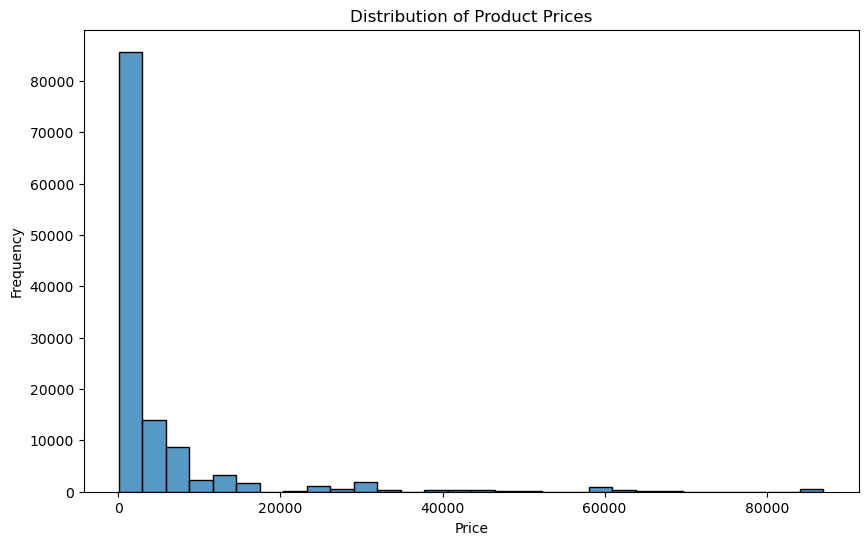

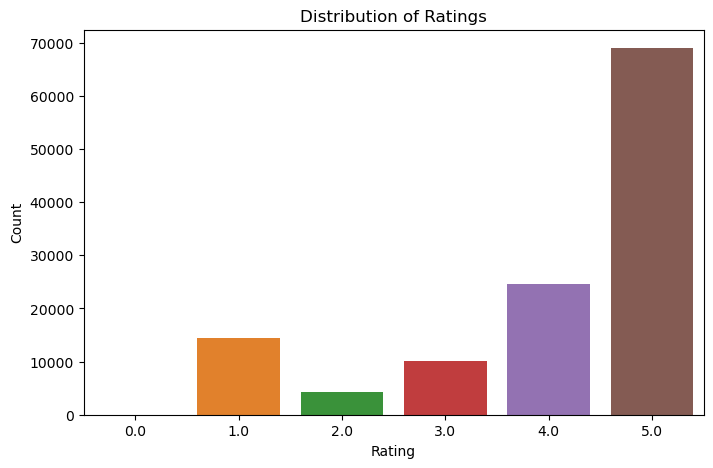

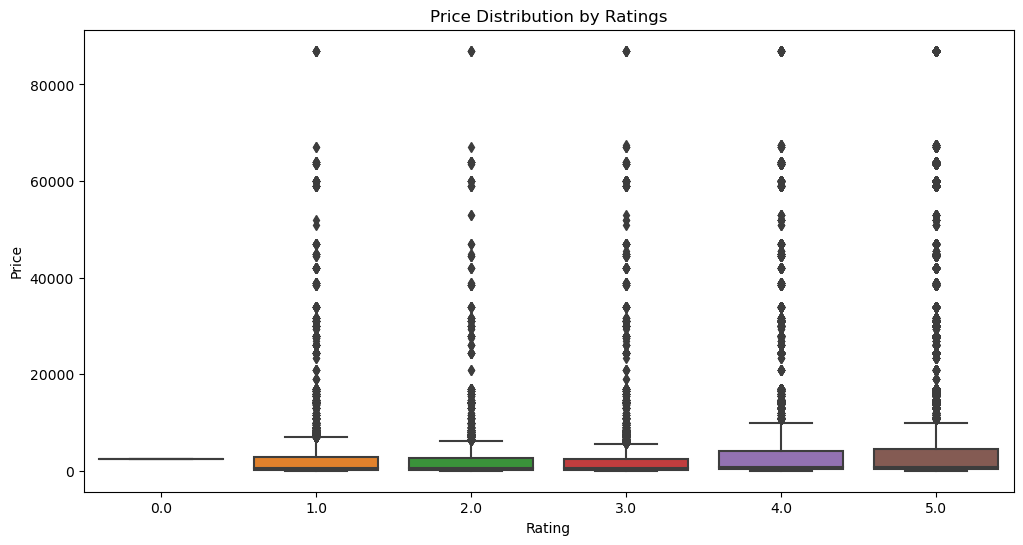

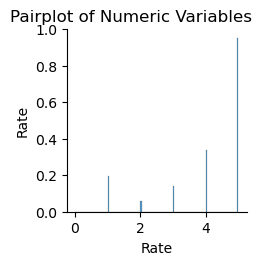

In [5]:
numeric_columns = ['Price','Rate']
# Histogram of Price
plt.figure(figsize=(10, 6))
sns.histplot(data=flipkart_df, x='Price', bins=30)
plt.title("Distribution of Product Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# Countplot of Ratings
plt.figure(figsize=(8, 5))
sns.countplot(data=flipkart_df, x='Rate')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Boxplot of Price by Rating
plt.figure(figsize=(12, 6))
sns.boxplot(data=flipkart_df, x='Rate', y='Price')
plt.title("Price Distribution by Ratings")
plt.xlabel("Rating")
plt.ylabel("Price")
plt.show()

#Pairplot (scatterplot matrix) for numeric variables
numeric_columns = flipkart_df.select_dtypes(include=['float64']).columns
sns.pairplot(flipkart_df[numeric_columns])
plt.suptitle("Pairplot of Numeric Variables", y=1.02)
plt.show()

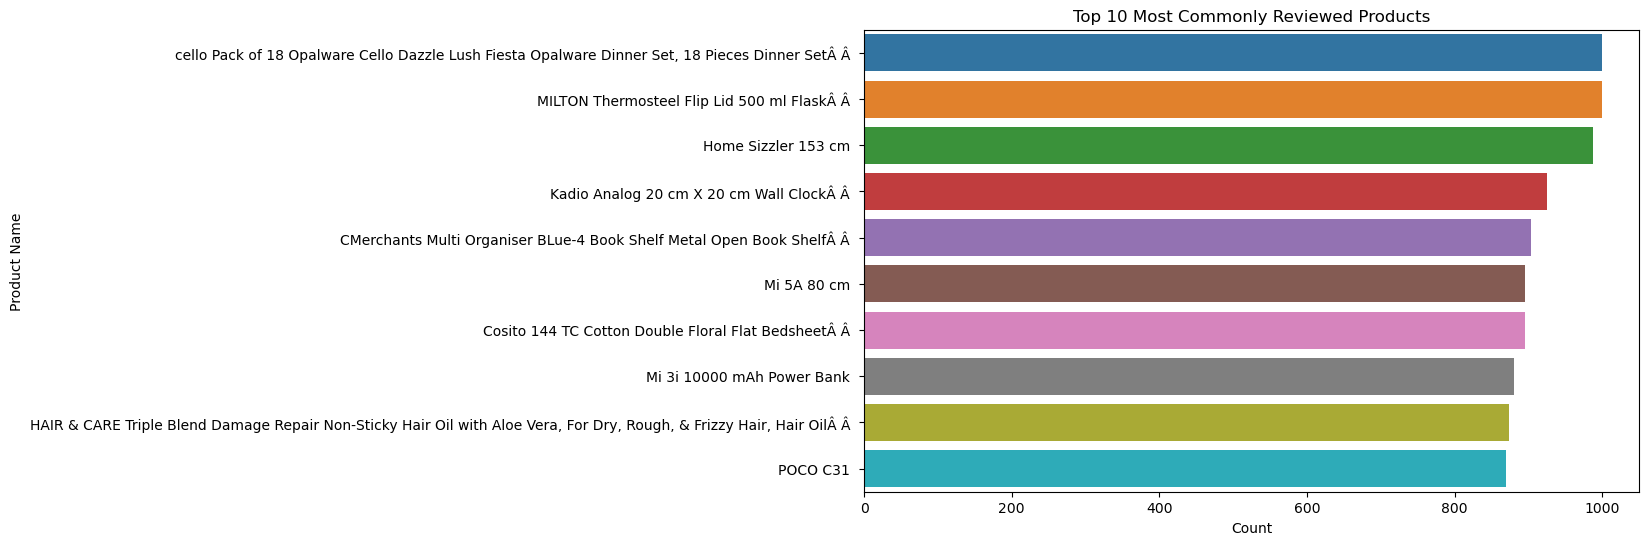

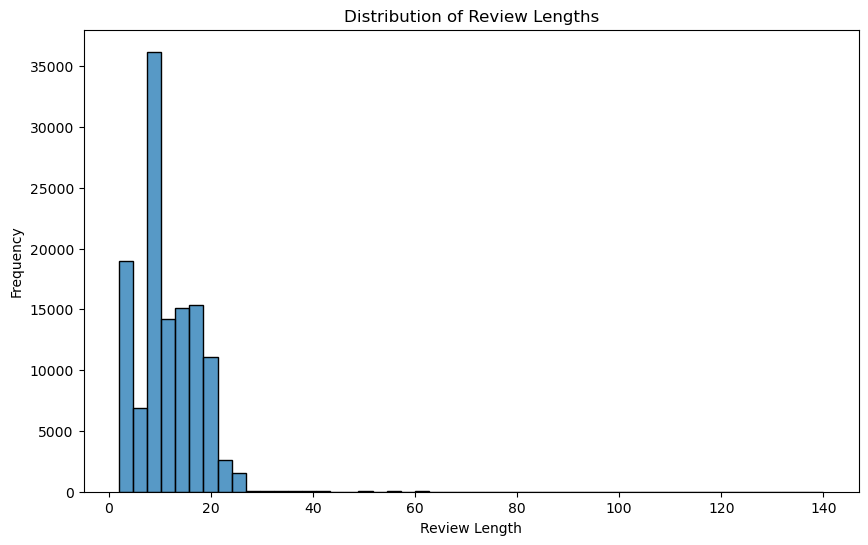

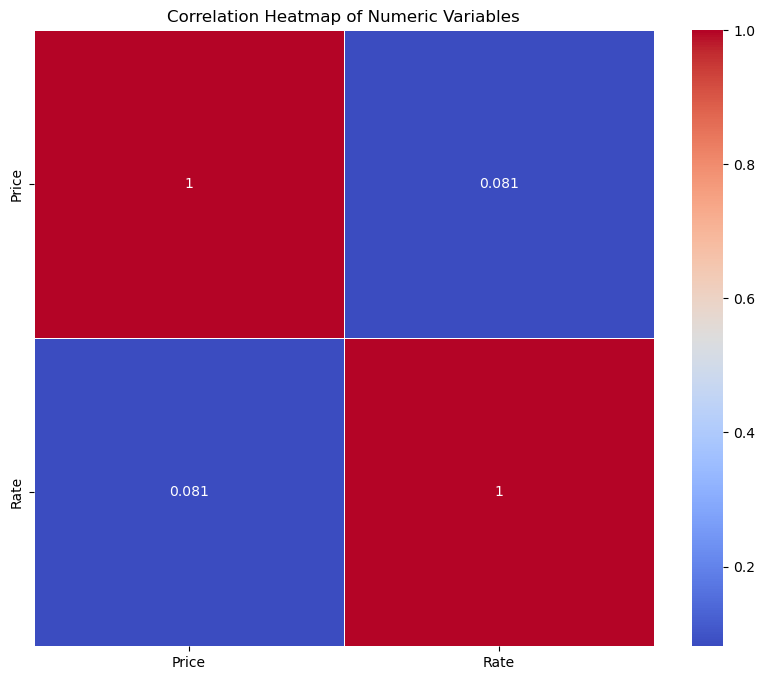

In [6]:
numeric_columns = ['Price','Rate']
#Bar plot of the most common products
plt.figure(figsize=(10, 6))
top_products = flipkart_df['ProductName'].value_counts().head(10)
sns.barplot(x=top_products.values, y=top_products.index, orient='h')
plt.title("Top 10 Most Commonly Reviewed Products")
plt.xlabel("Count")
plt.ylabel("Product Name")
plt.show()

# Distribution of review lengths
flipkart_df['Review_Length'] = flipkart_df['Review'].str.len()  # Create a new column for review lengths
plt.figure(figsize=(10, 6))
sns.histplot(data=flipkart_df, x='Review_Length', bins=50)
plt.title("Distribution of Review Lengths")
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.show()



# Correlation heatmap of numeric columns
plt.figure(figsize=(10, 8))
correlation_matrix = flipkart_df[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Variables")
plt.show()

<h3 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Data Transformation
            </span>   
        </font>    
</h3>

In [7]:
user_item_matrix = flipkart_df.pivot(index='UserID', columns='ProductName', values='Rate')

# Fill missing values (NaN) with 0 if needed
user_item_matrix = user_item_matrix.fillna(0)
user_item_matrix

ProductName   1170-BL-BR Unique New Day & Date Analog Watch  - For Men  \
UserID                                                                   
FLP20IND1924                                                0.0          
FLP20IND1925                                                0.0          
FLP20IND1926                                                0.0          
FLP20IND1927                                                0.0          
FLP20IND1928                                                0.0          
...                                                         ...          
FLP20IND2919                                                0.0          
FLP20IND2920                                                5.0          
FLP20IND2921                                                0.0          
FLP20IND2922                                                0.0          
FLP20IND2923                                                0.0          

ProductName   38024PP25 Minimalists Analog Watch  - For Men  \
UserID                                                        
FLP20IND1924                                            0.0   
FLP20IND1925                                            0.0   
FLP20IND1926                                            0.0   
FLP20IND1927                                            0.0   
FLP20IND1928                                            0.0   
...                                                     ...   
FLP20IND2919                                            0.0   
FLP20IND2920                                            0.0   
FLP20IND2921                                            0.0   
FLP20IND2922                                            0.0   
FLP20IND2923                                            0.0   

ProductName   3D METRO SUPER STORE JUICER_Gduumy 1 Juicer,1 Handle,1 Jar,1 Glass 0 Juicer   \
UserID                                                                                       
FLP20IND1924                                                0.0                              
FLP20IND1925                                                0.0                              
FLP20IND1926                                                0.0                              
FLP20IND1927                                                0.0                              
FLP20IND1928                                                0.0                              
...                                                         ...                              
FLP20IND2919                                                0.0                              
FLP20IND2920                                                0.0                              
FLP20IND2921                                                0.0                              
FLP20IND2922                                                0.0                              
FLP20IND2923                                                0.0                              

ProductName   3D METRO SUPER STORE METRO_MIXER Pro 0 Juicer   \
UserID                                                         
FLP20IND1924                                             0.0   
FLP20IND1925                                             0.0   
FLP20IND1926                                             0.0   
FLP20IND1927                                             0.0   
FLP20IND1928                                             0.0   
...                                                      ...   
FLP20IND2919                                             0.0   
FLP20IND2920                                             0.0   
FLP20IND2921                                             0.0   
FLP20IND2922                                             0.0   
FLP20IND2923                                             0.0   

ProductName   77085PP03 Volt Analog Watch  - For Men  \
UserID                                                 
FLP20IND1924                                     

In [8]:
# Exporting the matrix
user_item_matrix.to_csv('user_item_matrix.csv' )

<h3 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Recommendation System using UBCF & IBCF
            </span>   
        </font>    
</h3>

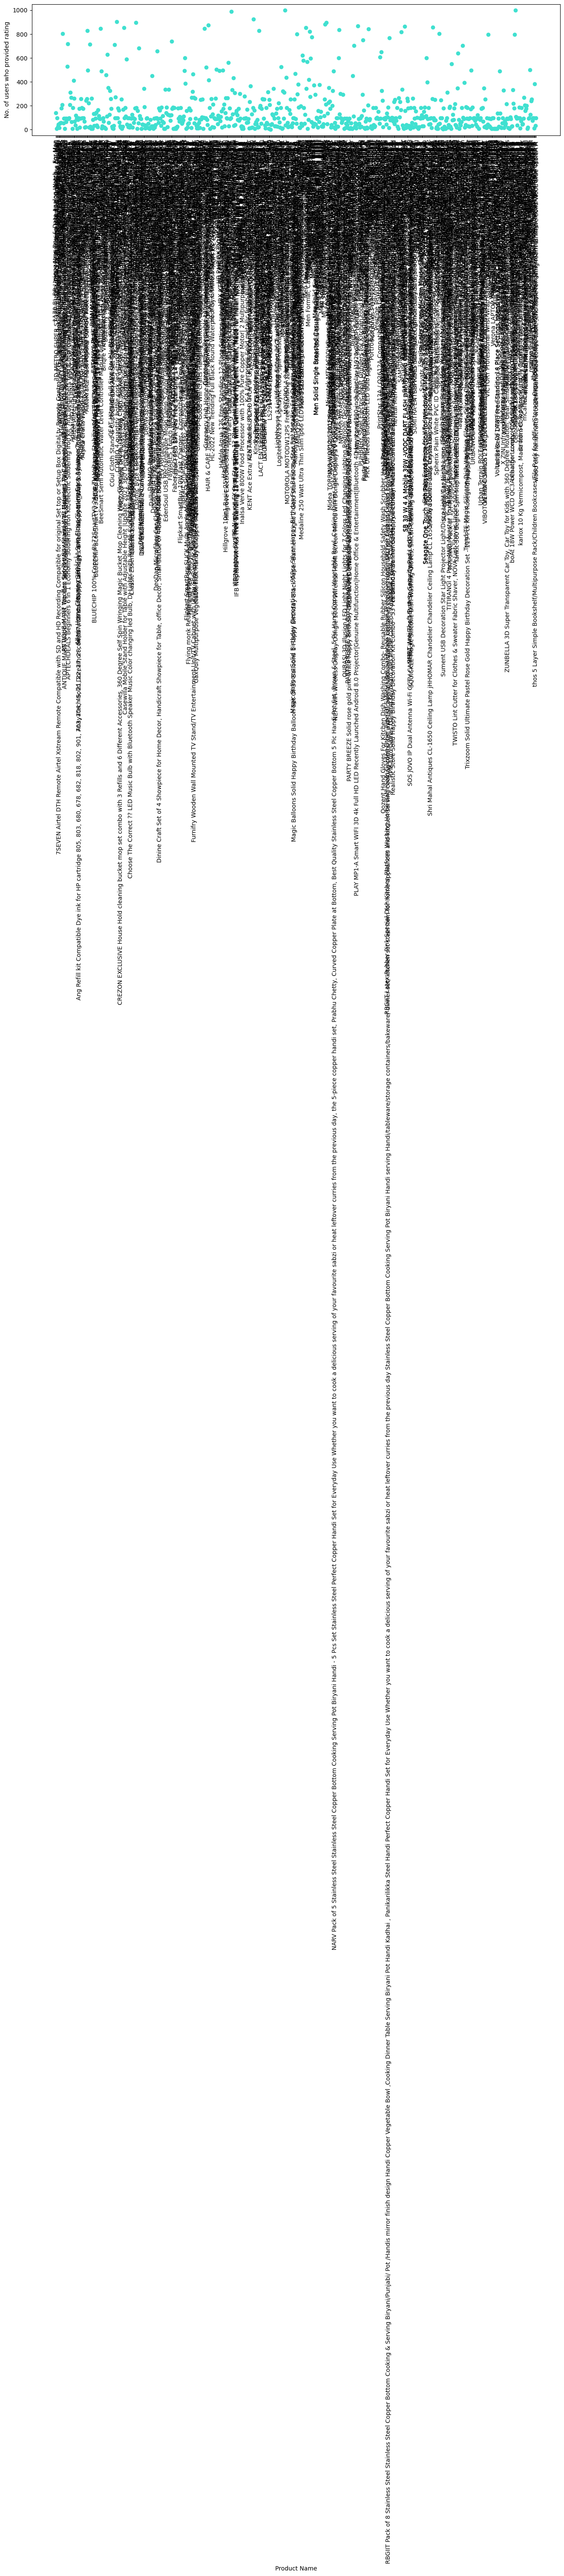

In [9]:
# Visualizing the Users who have rated
no_user_rated = (user_item_matrix[user_item_matrix > 0]).count()

f, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.scatter(no_user_rated.index, no_user_rated, color='turquoise')
plt.xlabel('Product Name')
plt.ylabel('No. of users who provided rating')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

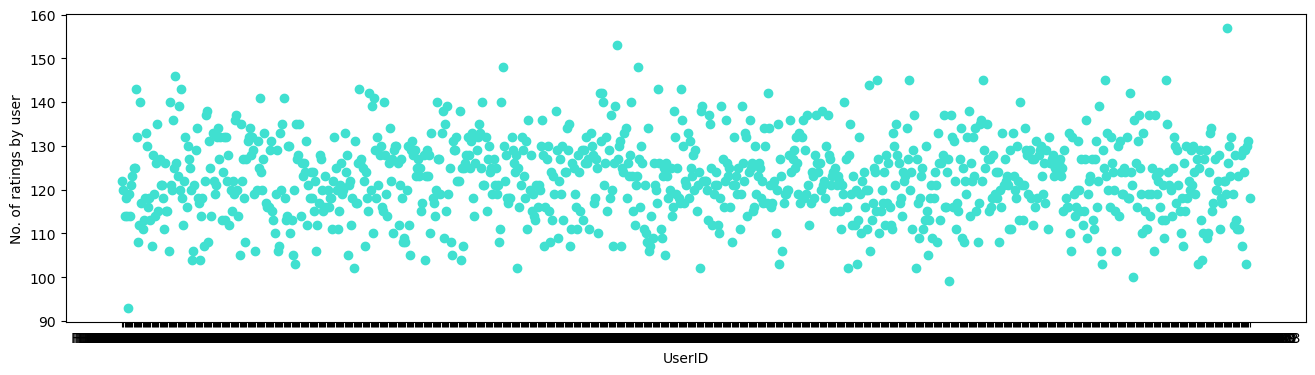

In [10]:
# Visualizing the Products which have been rated

no_products_rated = (user_item_matrix[user_item_matrix > 0]).count(axis=1)

f, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.scatter(no_products_rated.index, no_products_rated, color='turquoise')
plt.xlabel('UserID')
plt.ylabel('No. of ratings by user')
plt.show()

In [11]:
# Finding the unique number of users and products

n_users = flipkart_df['UserID'].nunique()
n_items = flipkart_df['ProductName'].nunique()

print(f"Total No. of Users: {n_users}")
print(f"Total No. of Products: {n_items}")

Total No. of Users: 1000
Total No. of Products: 764


In [12]:
# Splitting our dataset into train and test
train_user_item, test_user_item = tts(user_item_matrix, test_size=0.2, random_state=24)
print("Shape of train_user_item:", train_user_item.shape)
print("Shape of test_user_item:", test_user_item.shape)

Shape of train_user_item: (800, 764)
Shape of test_user_item: (200, 764)


In [13]:
# Finding User-User Similarity
user_similarity = cosine_similarity(train_user_item)
user_similarity 

array([[1.        , 0.3581826 , 0.36670427, ..., 0.32118367, 0.37619323,
        0.36666117],
       [0.3581826 , 1.        , 0.34840743, ..., 0.36089742, 0.32921485,
        0.34836591],
       [0.36670427, 0.34840743, 1.        , ..., 0.33654069, 0.34231811,
        0.37906489],
       ...,
       [0.32118367, 0.36089742, 0.33654069, ..., 1.        , 0.35299334,
        0.37548431],
       [0.37619323, 0.32921485, 0.34231811, ..., 0.35299334, 1.        ,
        0.36934168],
       [0.36666117, 0.34836591, 0.37906489, ..., 0.37548431, 0.36934168,
        1.        ]])

In [14]:
# Finding Item-Item Similarity
item_similarity = cosine_similarity(train_user_item.T)
item_similarity

array([[1.        , 0.        , 0.07957707, ..., 0.22829512, 0.04051006,
        0.20269111],
       [0.        , 1.        , 0.08501618, ..., 0.06691038, 0.        ,
        0.        ],
       [0.07957707, 0.08501618, 1.        , ..., 0.15844746, 0.04357156,
        0.08151373],
       ...,
       [0.22829512, 0.06691038, 0.15844746, ..., 1.        , 0.04064258,
        0.13459729],
       [0.04051006, 0.        , 0.04357156, ..., 0.04064258, 1.        ,
        0.04932503],
       [0.20269111, 0.        , 0.08151373, ..., 0.13459729, 0.04932503,
        1.        ]])

In [15]:
# User & Item-Based Collaborative Filtering
def predict(ratings, similarity, type='user'):
    if type == 'user':   
        mean_user_rating = ratings.mean(axis=1)
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / (1 + np.array([np.abs(similarity).sum(axis=1)]))
    return pred

# UBCF prediction
ubcf_predictions = predict(train_user_item, user_similarity,type='user')

# IBCF prediction
ibcf_predictions = predict(train_user_item, item_similarity,type='item')

print(ubcf_predictions.shape)
print(ibcf_predictions.shape)

(800, 764)
(800, 764)


In [16]:
# Defining a Recommendation Function 
def recommend_products_for_user(user, user_item_matrix, preds, K):
    recos = {'ProductName': [], 'Rating': []}
    
    # Find the index corresponding to the user ID
    user_index = user_item_matrix.index.get_loc(user)
    
    user_array = preds[user_index]
    orig_ratings = user_item_matrix.loc[user]

    for product_id in range(len(orig_ratings)):
        if orig_ratings[product_id] == 0:
            recos['ProductName'].append(user_item_matrix.columns[product_id])
            recos['Rating'].append(user_array[product_id])

    recos_df = pd.DataFrame(recos)
    recommend_df = recos_df.sort_values(by='Rating', ascending=False).head(K)

    return recommend_df

In [17]:
# Generating Recommendations for a particular user which has not rated all items based on UBCF
user_id = "FLP20IND1924"  
top_k_recommendations = 5
ubcf_recommendations = recommend_products_for_user(user_id, test_user_item, ubcf_predictions, top_k_recommendations)

print('User-based Collaborative Filtering: “Recommendation based on similar users as yours …”', user_id)
ubcf_recommendations

User-based Collaborative Filtering: “Recommendation based on similar users as yours …” FLP20IND1924


ProductName    Rating
201                                  Google Nest Mini   3.230219
154  FLIPZON Baby 6 Shelve Unbreakable Material PVC...  3.173778
415                   Pigeon Favourite Electric Kettle  3.142855
342         Men Graphic Print Round Neck Black T-Shirt  2.973704
134  Dettol Effective Protection Antiseptic LiquidÂ Â   2.917208

In [18]:
# Generating Recommendations for a particular user which has not rated all items based on IBCF
user_id = "FLP20IND1924"  
top_k_recommendations = 5  
ibcf_recommendations = recommend_products_for_user(user_id, test_user_item, ibcf_predictions, top_k_recommendations)

print('Item-based Collaborative Filtering: “Recommendation based on similar products as yours …”', user_id)
ibcf_recommendations

Item-based Collaborative Filtering: “Recommendation based on similar products as yours …” FLP20IND1924


ProductName    Rating
71   CAPIO ART GEOMETRIC multipurpose design Wood K...  1.399482
553                  ULTRA Perfect + 2.0 L Wet Grinder  1.388657
9    AGAMI Green 2 Layer Lucky Bamboo plant with Bi...  1.360215
194    Glen ISPA 90 BL Auto Clean Wall Mounted Chimney  1.355717
237  IFB Neptune SX1 Free Standing 15 Place Setting...  1.340633

In [19]:
# Defining and Checking the sparsity for Model Evaluation
def sparsity(matrix):
    total_elements = matrix.size
    zero_elements = np.count_nonzero(matrix == 0)
    sparsity = (zero_elements / total_elements) * 100
    return sparsity

sparsity_percentage = sparsity(train_user_item)
print("Sparsity of the user-item matrix:", sparsity_percentage, "%")


Sparsity of the user-item matrix: 83.94748036649214 %


In [21]:
# Evaluating the UBCF Model 
# Get the row (user) index corresponding to the user_id
user_index = np.where(user_item_matrix.index == user_id)[0]

if len(user_index) == 0:
    # Handle the case where the user_id is not found in the user_item_matrix
    print(f"User with ID {user_id} not found in the user-item matrix.")
else:
    user_index = user_index[0]  # Get the first (and presumably only) index found

    # Extract the actual ratings for the user (non-NaN values in the row)
    actual_ratings = user_item_matrix.iloc[user_index].dropna().values

    # Extract the predicted ratings for the same items (using corresponding column indices)
    item_indices = np.where(~np.isnan(actual_ratings))[0]  # Get indices of non-NaN values
    predicted_ratings = ubcf_predictions[user_index, item_indices]

    # Now, actual_ratings and predicted_ratings contain the user's actual and predicted ratings, respectively

    mae = mean_absolute_error(actual_ratings, predicted_ratings)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Absolute Error (MAE): 0.86


<h3 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Association of Products using Apriori Algorithm
            </span>   
        </font>    
</h3>

In [23]:
# Convert values to 1 if >= 3, else 0
threshold = 3

# Convert ratings to binary values (1 if rating >= threshold, 0 if rating < threshold)
basket = user_item_matrix.applymap(lambda x: 1 if x >= threshold else 0)

In [24]:
# Finding Associated Products
min_support = 0.4
min_confidence = 0.5
lift_threshold = 1

# Generate frequent itemsets using Apriori algorithm with min_support
frequent_itemsets = apriori(basket, min_support=min_support, use_colnames=True)
# Generate association rules with min_confidence and lift_threshold
association_rules_df = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_confidence)
# Filter rules with a length of 2 or more and lift >= lift_threshold
filtered_rules = association_rules_df[(association_rules_df['antecedents'].apply(len) >= 2) & (association_rules_df['lift'] >= lift_threshold)]

filtered_rules

antecedents  \
1696    (AGARO Regal Hand-held Vacuum CleanerÂ Â , APP...   
1711    (Canon EOS 3000D DSLR Camera 1 Camera Body, 18...   
1712    (Canon EOS 3000D DSLR Camera 1 Camera Body, 18...   
1713    (AGARO Regal Hand-held Vacuum CleanerÂ Â , BAJ...   
1719    (HAIR & CARE Triple Blend Damage Repair Non-St...   
...                                                   ...   
142413  (SAMSUNG EVO Plus 64 GB MicroSDXC Class 10 95 ...   
142418               (Mi 5A 80 cm , Home Sizzler 153 cm )   
142424  (MILTON Thermosteel Flip Lid 500 ml FlaskÂ Â ,...   
142480  (SAMSUNG EVO Plus 64 GB MicroSDXC Class 10 95 ...   
142537  (SAMSUNG EVO Plus 64 GB MicroSDXC Class 10 95 ...   

                                              consequents  antecedent support  \
1696                               (Home Sizzler 153 cm )               0.467   
1711                   (BAJAJ 15 L Storage Water Geyser )               0.561   
1712           (AGARO Regal Hand-held Vacuum CleanerÂ Â )               0.575   
1713    (Canon EOS 3000D DSLR Camera 1 Camera Body, 18...               0.498   
1719           (AGARO Regal Hand-held Vacuum CleanerÂ Â )               0.596   
...                                                   ...                 ...   
142413  (MILTON Thermosteel Flip Lid 500 ml FlaskÂ Â ,...               0.667   
142418  (SAMSUNG EVO Plus 64 GB MicroSDXC Class 10 95 ...               0.782   
142424  (SAMSUNG EVO Plus 64 GB MicroSDXC Class 10 95 ...               0.687   
142480     (MILTON Thermosteel Flip Lid 500 ml FlaskÂ Â )               0.463   
142537     (MILTON Thermosteel Flip Lid 500 ml FlaskÂ Â )               0.444   

        consequent support  support  confidence      lift  leverage  \
1696                 0.954    0.446    0.955032  1.001082  0.000482   
1711                 0.712    0.405    0.721925  1.013940  0.005568   
1712                 0.690    0.405    0.704348  1.020794  0.008250   
1713                 0.806    0.405    0.813253  1.008999  0.003612   
1719                 0.690    0.422    0.708054  1.026165  0.010760   
...                    ...      ...         ...       ...       ...   
142413               0.604    0.408    0.611694  1.012739  0.005132   
142418               0.517    0.408    0.521739  1.009167  0.003706   
142424               0.585    0.408    0.593886  1.015191  0.006105   
142480               0.910    0.422    0.911447  1.001590  0.000670   
142537               0.910    0.405    0.912162  1.002376  0.000960   

        conviction  zhangs_metric  
1696      1.022952       0.002028  
1711      1.035692       0.031317  
1712      1.048529       0.047930  
1713      1.038839       0.017766  
1719      1.061839       0.063113  
...            ...            ...  
142413    1.019815       0.037773  
142418    1.009909       0.041667  
142424    1.021882       0.047806  
142480    1.016341       0.002957  
142537    1.024615       0.004263  

[67137 rows x 10 columns]

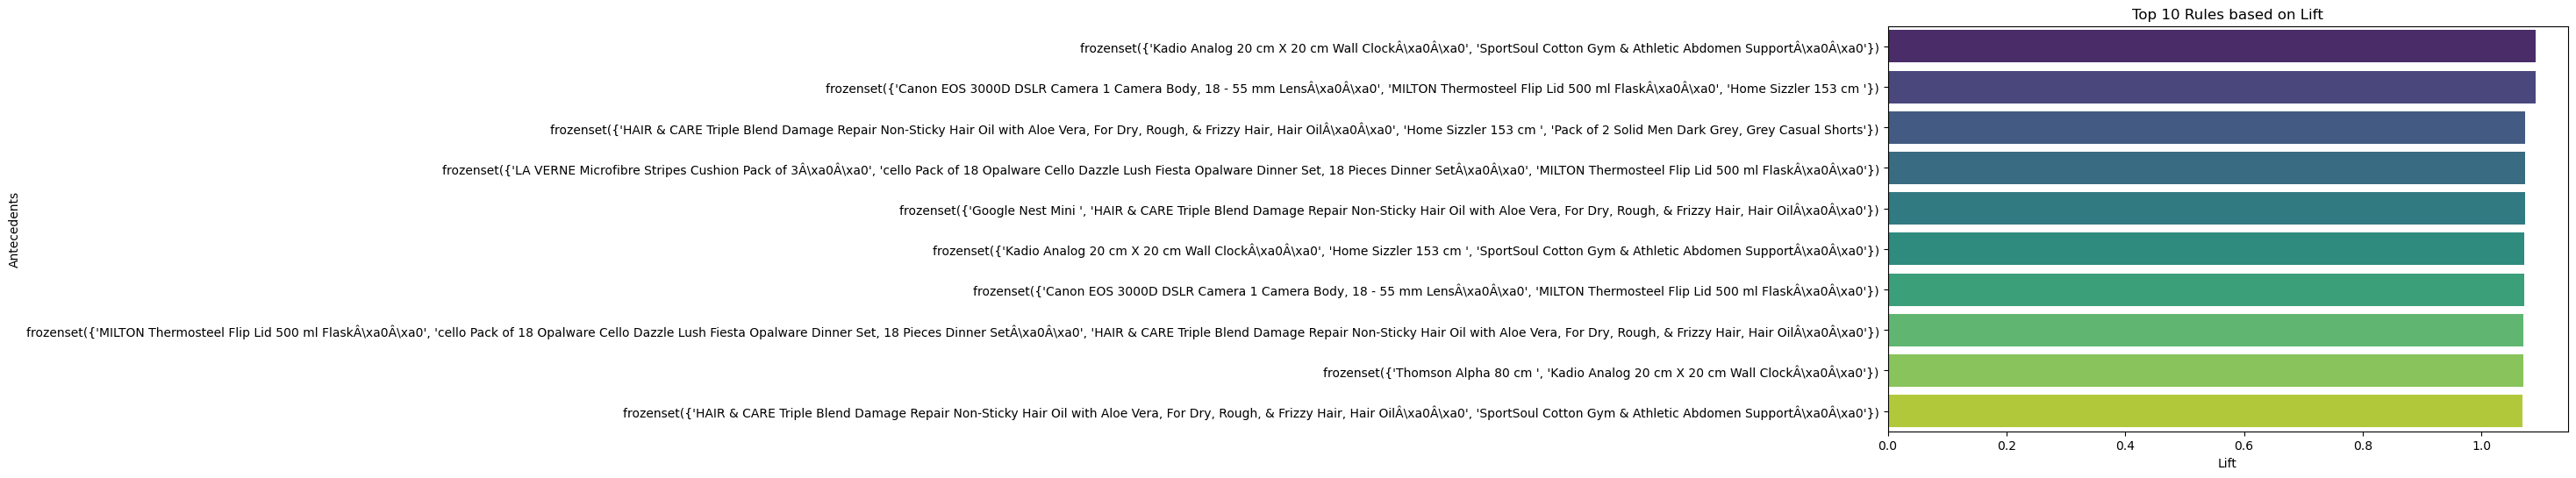

In [25]:
# Visualization: Bar Chart of Top Rules based on Lift
top_rules_lift = filtered_rules.sort_values(by='lift', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='lift', y='antecedents', data=top_rules_lift, palette='viridis')
plt.xlabel('Lift')
plt.ylabel('Antecedents')
plt.title('Top 10 Rules based on Lift')
plt.show()


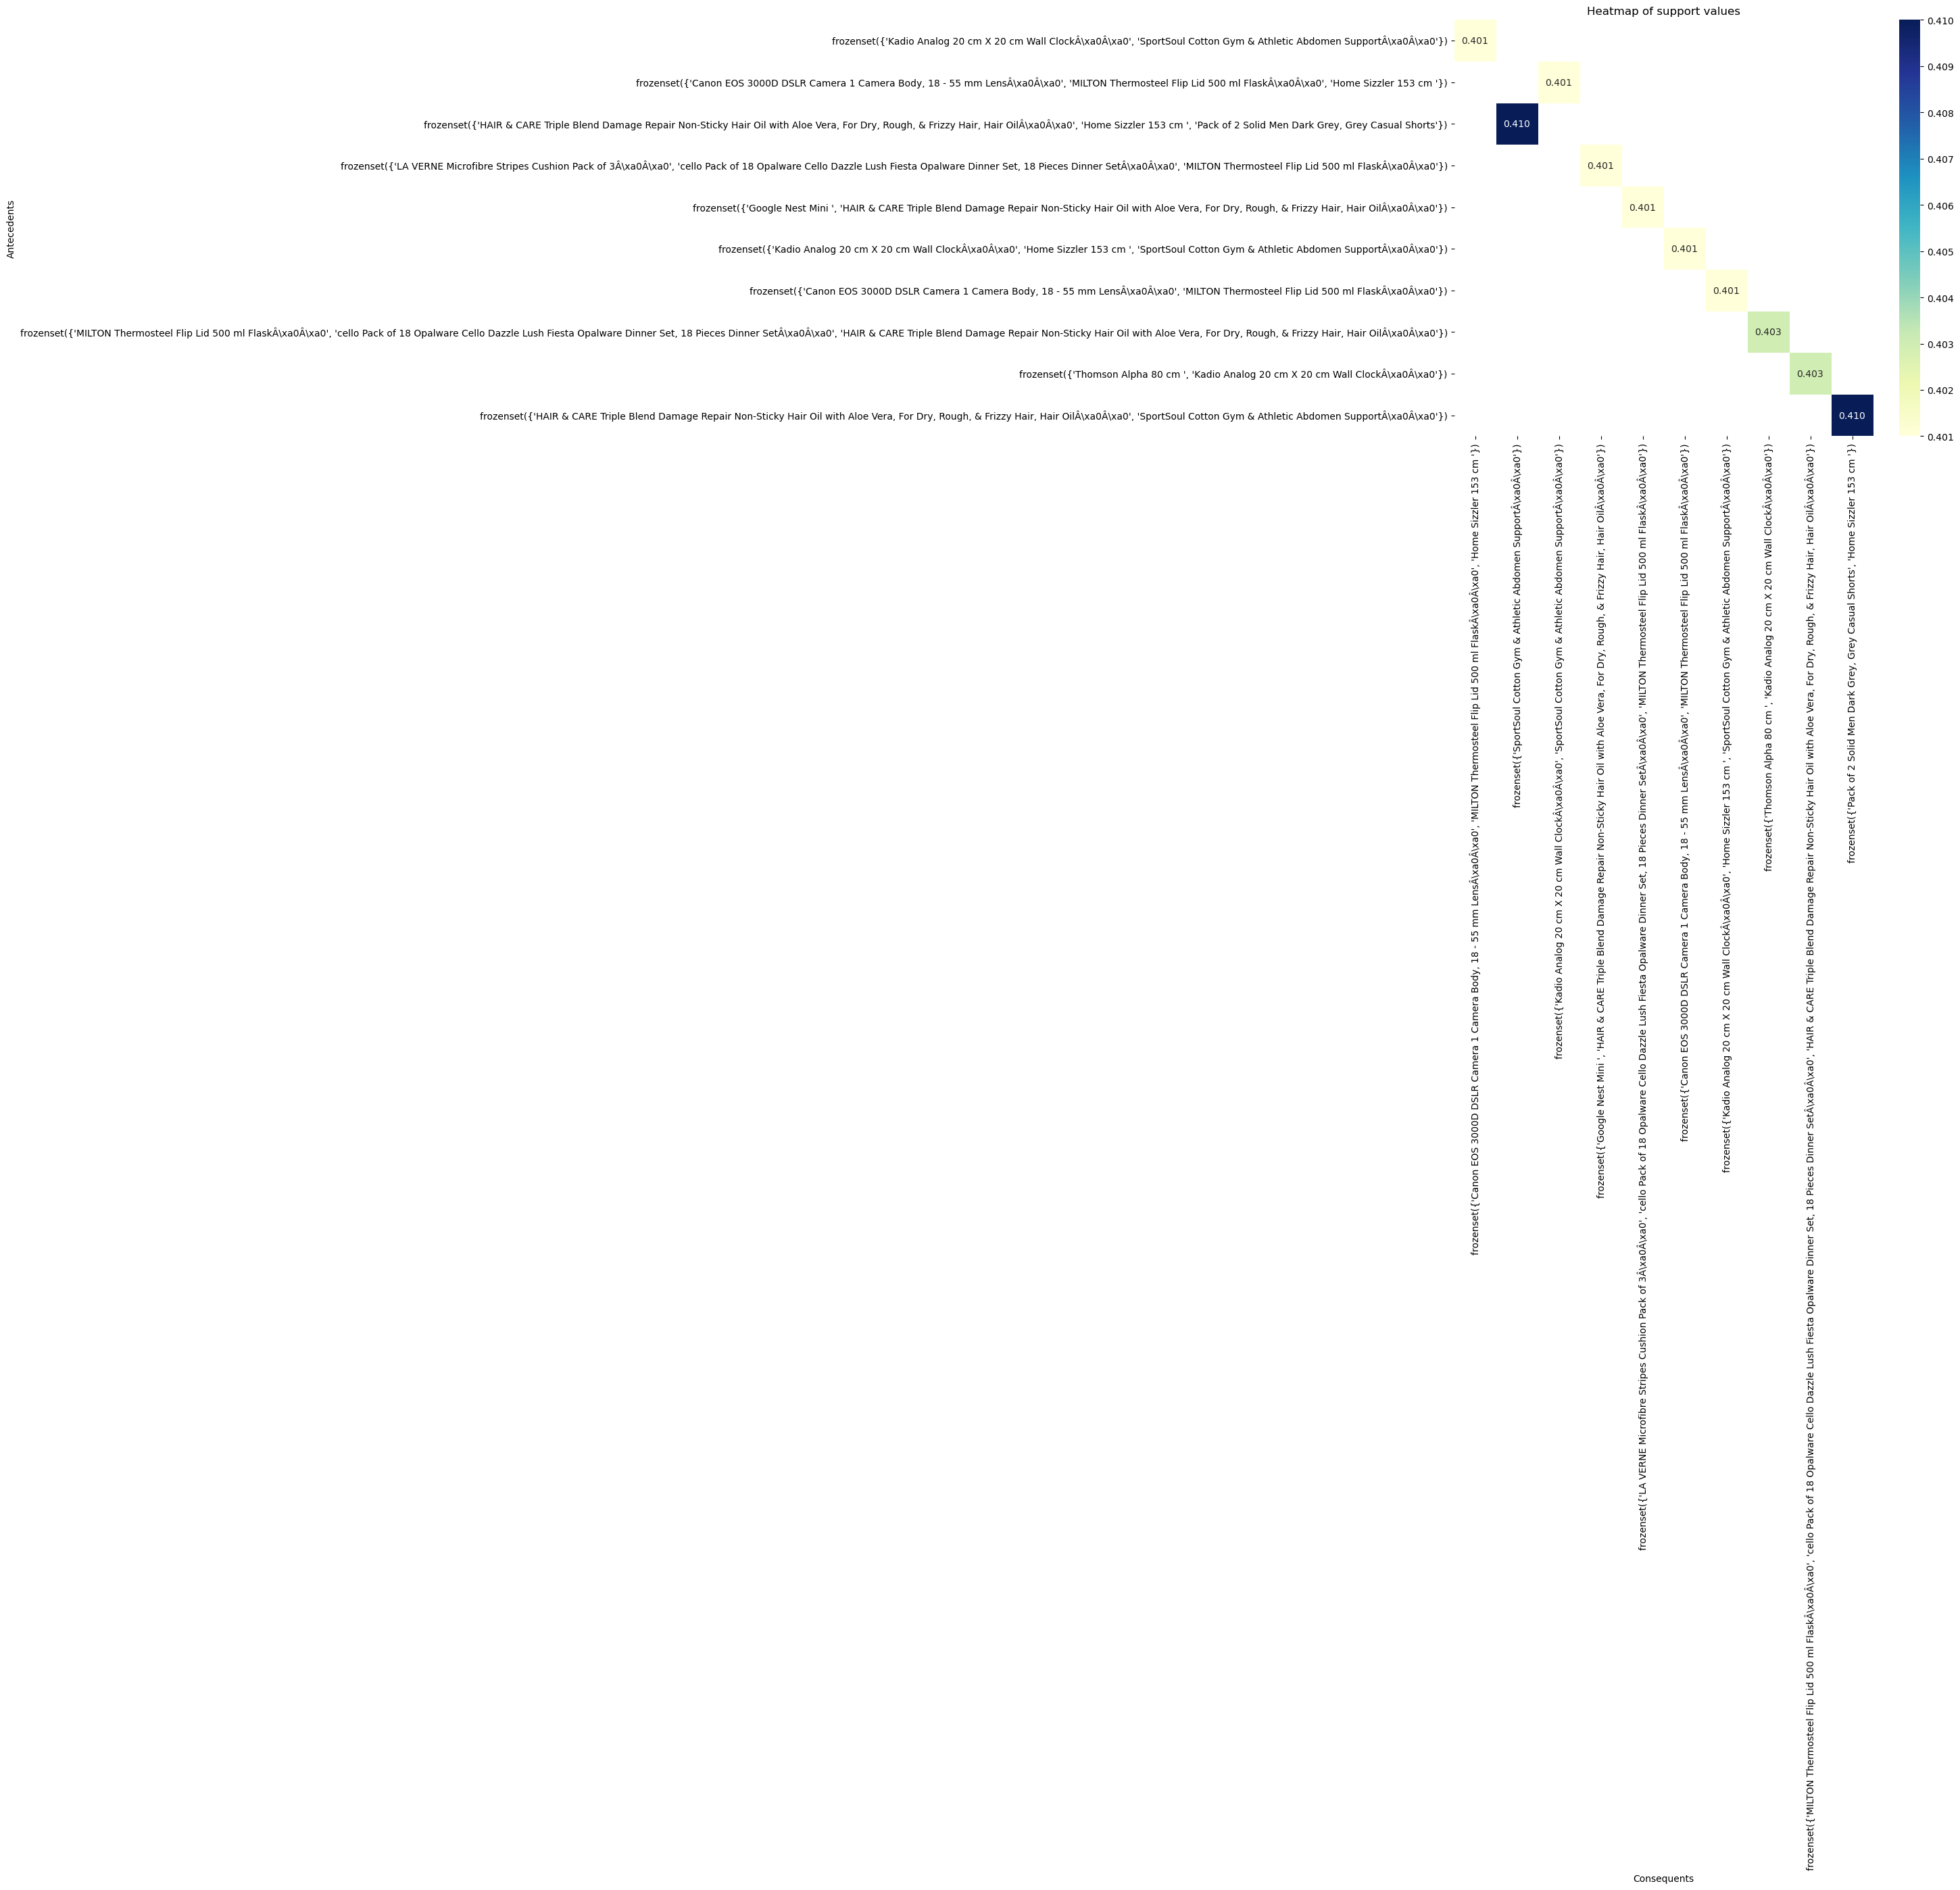

In [26]:
# Visualization : Heatmap of Rule Metrics
metrics = ['support', 'confidence', 'lift']
heatmap_data = top_rules_lift.pivot(index='antecedents', columns='consequents', values=metrics[0])
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".3f")
plt.xlabel('Consequents')
plt.ylabel('Antecedents')
plt.title(f'Heatmap of {metrics[0]} values')
plt.show()

<h3 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Sentimental Analysis of Customer Reviews
            </span>   
        </font>    
</h3>

In [27]:
# Finding the review length of each customer feedback
flipkart_df['Summary'] = flipkart_df['Summary'].astype(str)
flipkart_df['review_length'] = flipkart_df['Summary'].apply(len)
flipkart_df.rename(columns = {'Summary':'feedback'}, inplace = True)
flipkart_df

UserID                                        ProductName  \
0       FLP20IND2522               Candes 12 L Room/Personal Air Cooler   
1       FLP20IND2689               Candes 12 L Room/Personal Air Cooler   
2       FLP20IND2281               Candes 12 L Room/Personal Air Cooler   
3       FLP20IND2500               Candes 12 L Room/Personal Air Cooler   
4       FLP20IND2013               Candes 12 L Room/Personal Air Cooler   
...              ...                                                ...   
124294  FLP20IND2909  NIVEA Soft Light Moisturizer for Face, Hand & ...   
124295  FLP20IND2897  NIVEA Soft Light Moisturizer for Face, Hand & ...   
124296  FLP20IND2500  NIVEA Soft Light Moisturizer for Face, Hand & ...   
124297  FLP20IND2086  NIVEA Soft Light Moisturizer for Face, Hand & ...   
124298  FLP20IND1959  NIVEA Soft Light Moisturizer for Face, Hand & ...   

        Price  Rate               Review  \
0        3999   5.0               Super!   
1        3999   5.0              Awesome   
2        3999   3.0                 Fair   
3        3999   1.0      Useless product   
4        3999   3.0                 Fair   
...       ...   ...                  ...   
124294    142   5.0     Perfect product!   
124295    142   5.0              Awesome   
124296    142   5.0        Great product   
124297    142   5.0  Best in the market!   
124298    142   5.0             Terrific   

                                                 feedback  Review_Length  \
0       Great cooler.. excellent air flow and for this...            6.0   
1                  Best budget 2 fit cooler. Nice cooling            7.0   
2       The quality is good but the power of air is de...            4.0   
3                      Very bad product it's a only a fan           15.0   
4                                           Ok ok product            4.0   
...                                                   ...            ...   
124294  Smooth delivery by your delivery agent. Produc...           16.0   
124295                                               Good            7.0   
124296  It's a nice product...thanks very much to Flip...           13.0   
124297                                      Thanks â¤ï¸           19.0   
124298                                               Good            8.0   

        review_length  
0                 106  
1                  38  
2                  50  
3                  34  
4                  13  
...               ...  
124294             64  
124295              4  
124296             83  
124297             13  
124298              4  

[122475 rows x 8 columns]

In [28]:
# Data Preparation
review_df = flipkart_df[['feedback','review_length','Rate']]
review_df = review_df[review_df['Rate'] != 0]
review_df

feedback  review_length  Rate
0       Great cooler.. excellent air flow and for this...            106   5.0
1                  Best budget 2 fit cooler. Nice cooling             38   5.0
2       The quality is good but the power of air is de...             50   3.0
3                      Very bad product it's a only a fan             34   1.0
4                                           Ok ok product             13   3.0
...                                                   ...            ...   ...
124294  Smooth delivery by your delivery agent. Produc...             64   5.0
124295                                               Good              4   5.0
124296  It's a nice product...thanks very much to Flip...             83   5.0
124297                                      Thanks â¤ï¸             13   5.0
124298                                               Good              4   5.0

[122474 rows x 3 columns]

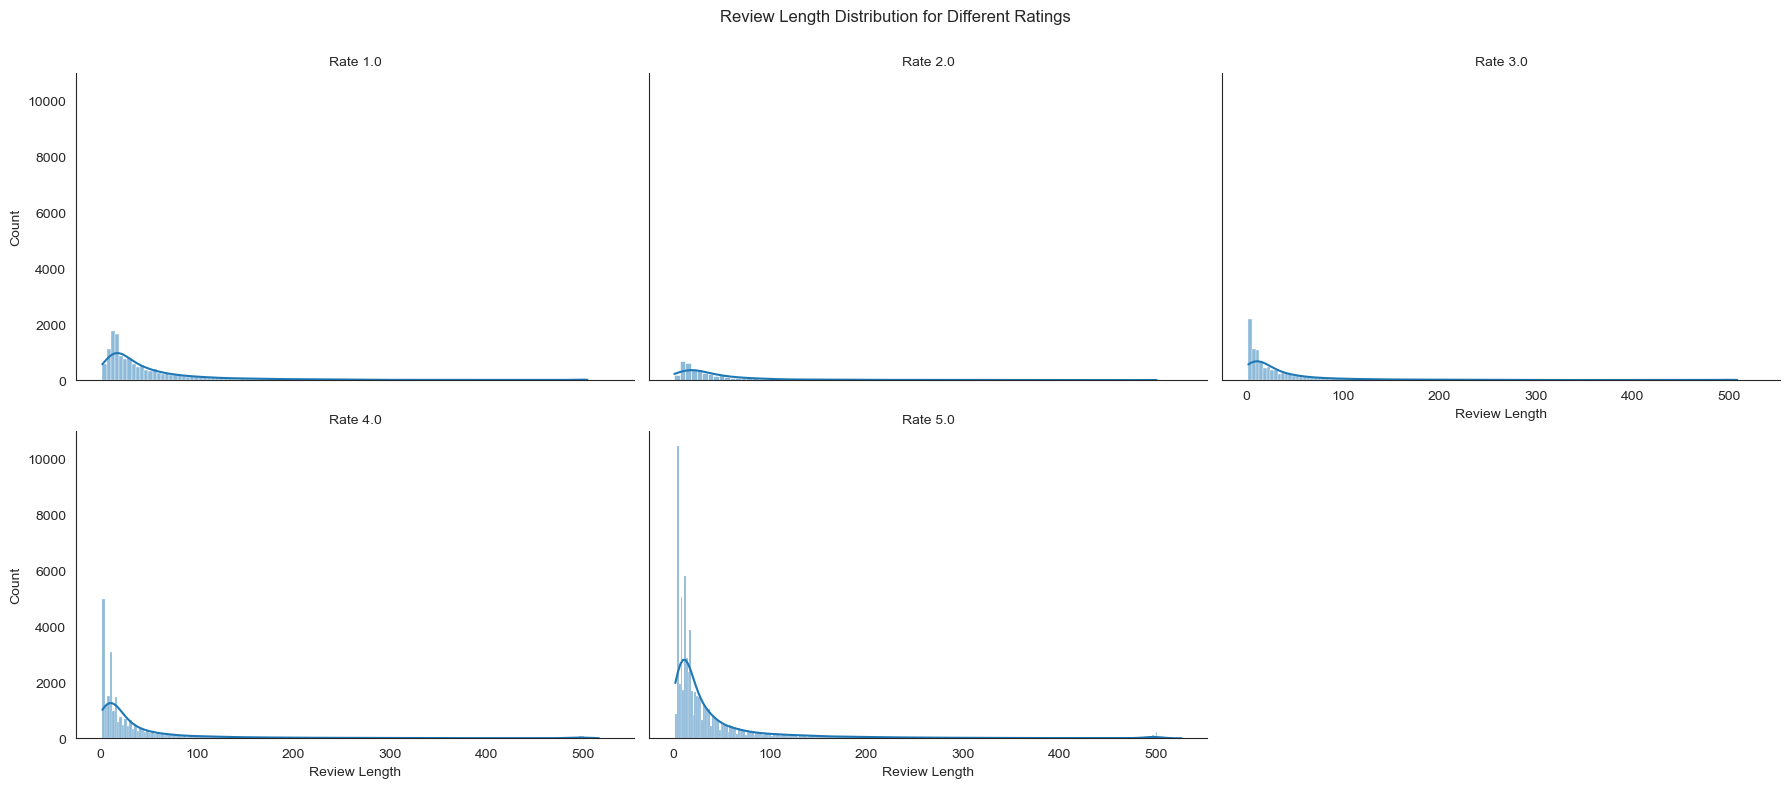

In [29]:
# Visualization: Review Length Distribution
sns.set_style('white')
g = sns.FacetGrid(review_df, col='Rate',col_wrap=3, height=4, aspect=1.5)
g.map(sns.histplot, 'review_length', kde=True)
g.set_axis_labels('Review Length', 'Count')
g.set_titles('Rate {col_name}')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Review Length Distribution for Different Ratings')
plt.show()

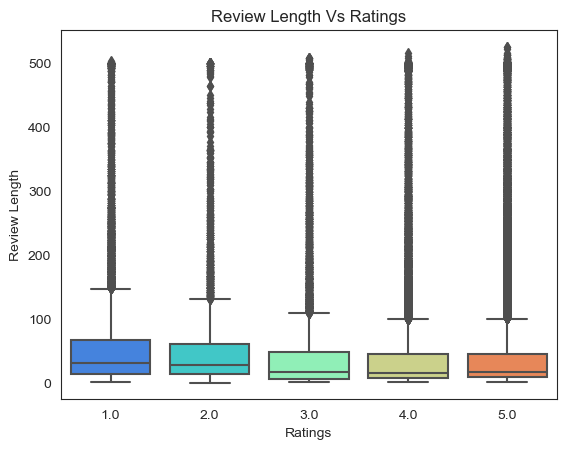

In [30]:
# Visualization: Review Length Vs Ratings

sns.boxplot(x = 'Rate', y='review_length', data=review_df , palette='rainbow')
# Set axis labels and title
plt.xlabel('Ratings')
plt.ylabel('Review Length')
plt.title('Review Length Vs Ratings')

plt.show()

is                  31001
product             28620
and                 23711
good                23163
Good                22019
                    ...  
premium.It              1
Color.Absolutely        1
somewhere.              1
Nyc....I                1
Thq.                    1
Length: 67052, dtype: int64


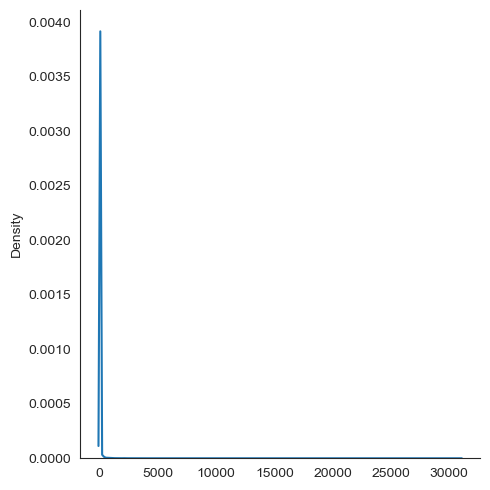

In [31]:
# Finding Frequency of each word in the customer reviews
freq = pd.Series(' '.join(review_df['feedback']).split()).value_counts()[:]
print(freq)
sns.displot(data=freq,kind='kde')

In [32]:
# Listing down each word in the customer reviews
list_of_words = pd.Series(' '.join(review_df['feedback']).split())
list_of_words

0              Great
1           cooler..
2          excellent
3                air
4               flow
             ...    
1059697         ð
1059698         ð
1059699       Thanks
1059700       â¤ï¸
1059701         Good
Length: 1059702, dtype: object

In [33]:
# Extracting feedback 
reviews = review_df['feedback']
reviews

0         Great cooler.. excellent air flow and for this...
1                    Best budget 2 fit cooler. Nice cooling
2         The quality is good but the power of air is de...
3                        Very bad product it's a only a fan
4                                             Ok ok product
                                ...                        
124294    Smooth delivery by your delivery agent. Produc...
124295                                                 Good
124296    It's a nice product...thanks very much to Flip...
124297                                        Thanks â¤ï¸
124298                                                 Good
Name: feedback, Length: 122474, dtype: object

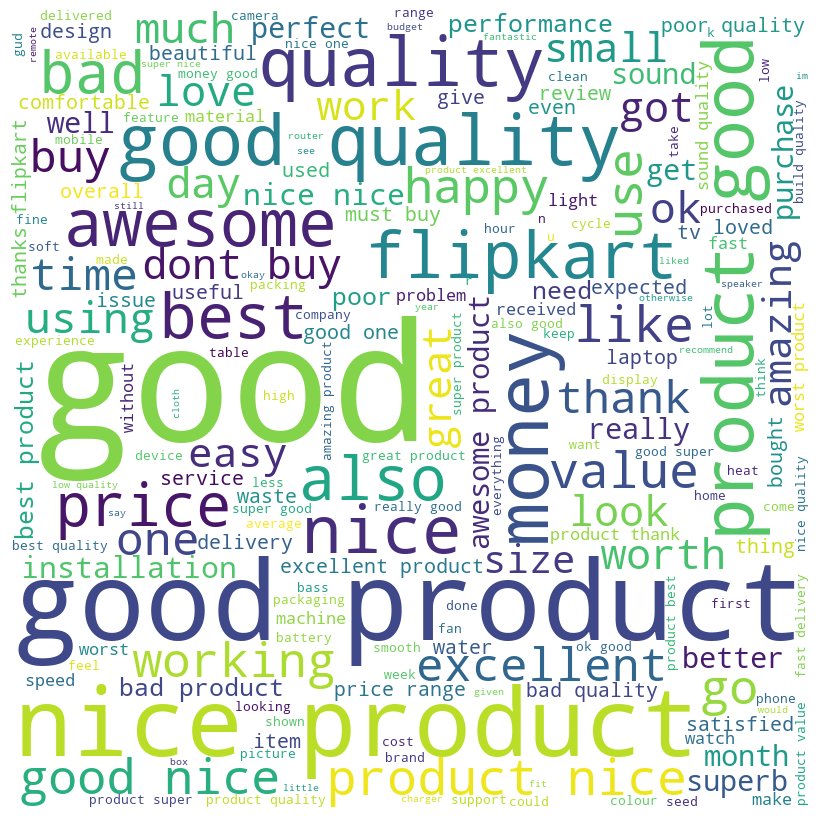

In [34]:
# Getting a list of stopwords for a specific language (e.g., English)
stop_words = set(stopwords.words('english'))

# Defining a function to remove non-English words using regular expressions
def remove_non_english(text):
    # Regular expression pattern to match English words
    english_pattern = re.compile(r'[a-zA-Z]+')
    # Find all English words in the text
    english_words = english_pattern.findall(text)
    # Join the English words into a single string
    return ' '.join(english_words)

review_words = ""

# Iterate through the reviews
for val in reviews:
    # Typecast each val to string - this is required to use word cloud functionality
    val = str(val)

    # Create the tokens by splitting on spaces
    tokens = val.split()

    # Converts each token into lowercase and remove symbols
    for i in range(len(tokens)):
        tokens[i] = re.sub(r'[^a-zA-Z]', '', tokens[i].lower())  # Remove non-alphabetic characters

    # Remove empty tokens and concatenate the cleaned tokens
    clean_tokens = [token for token in tokens if token != '']
    review_words += " ".join(clean_tokens) + " "

# Create a WordCloud with the cleaned and filtered text
word_cloud = WordCloud(width=800, height=800,
                       background_color='white',
                       stopwords=stop_words,  # Use the set of stopwords
                       min_font_size=10).generate(review_words)

# plot the WordCloud image                      
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


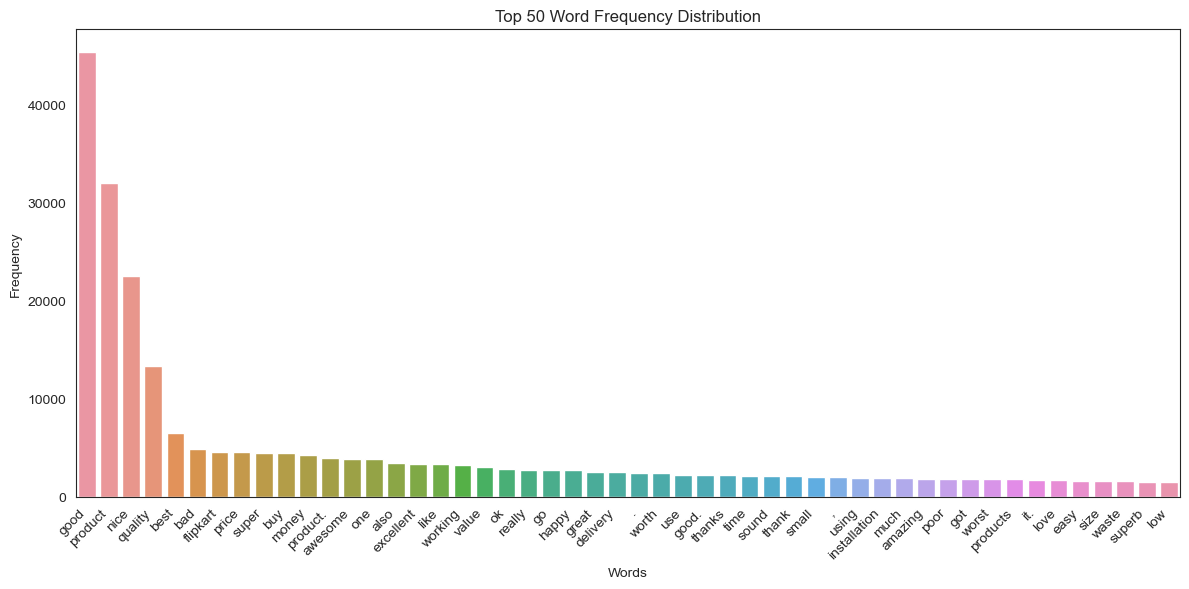

In [35]:
# Defining a Function to remove stopwords from the list_of_words
def remove_stopwords(words_list):
    return [word for word in words_list if word not in stop_words]

# Convert all words in the list_of_words to lower case
list_of_words_lower = list_of_words.str.lower()

# Remove stopwords from the list_of_words
filtered_words = remove_stopwords(list_of_words_lower)

# Count the frequency of remaining words
word_frequency = Counter(filtered_words)

# Convert the word frequency to a pandas DataFrame 
word_frequency_df = pd.DataFrame(word_frequency.items(), columns=['Word', 'Frequency'])

# Sort the DataFrame by frequency in descending order
word_frequency_df = word_frequency_df.sort_values(by='Frequency', ascending=False)

# Select the top N most frequent words for plotting
top_n = 50  # Change this value to plot a different number of top words
word_frequency_top_n = word_frequency_df.head(top_n)

# Plotting the top N word frequency distribution using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='Word', y='Frequency', data=word_frequency_top_n)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Word Frequency Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [36]:
# Initialize the VADER sentiment analyzer
vader = SentimentIntensityAnalyzer()

# Determine sentiments using VADER and create labels
review_df['sentiment'] = review_df['feedback'].apply(lambda x: 1 if vader.polarity_scores(x)['compound'] >= 0 else 0)


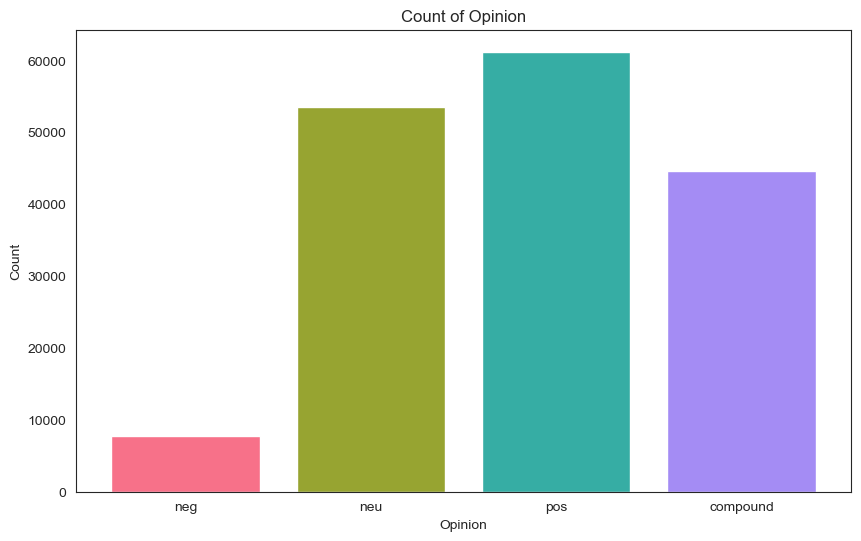

In [37]:
# Import Sentiment Analyzer - VADER 
# Initialize the sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

# Analyze sentiments using VADER
sentiments = []

for review in review_df['feedback']:
    sentiment_scores = analyzer.polarity_scores(review)
    sentiments.append(sentiment_scores)

# Create a new DataFrame with sentiment information
sentiments_df = pd.DataFrame(sentiments)

# Combine with the original DataFrame
result_df = pd.concat([reviews, sentiments_df], axis=1)

exclude_columns = ['feedback']  
# Get the columns to include in the X-axis 
x_columns = [col for col in result_df.columns if col not in exclude_columns]

# Create a colorful palette
palette = sns.color_palette("husl", len(x_columns))

# Create a bar plot with a colorful palette
plt.figure(figsize=(10, 6))
plt.bar(x_columns, result_df[x_columns].sum(), color=palette)
plt.xlabel('Opinion')
plt.ylabel('Count')
plt.title('Count of Opinion')
plt.show()

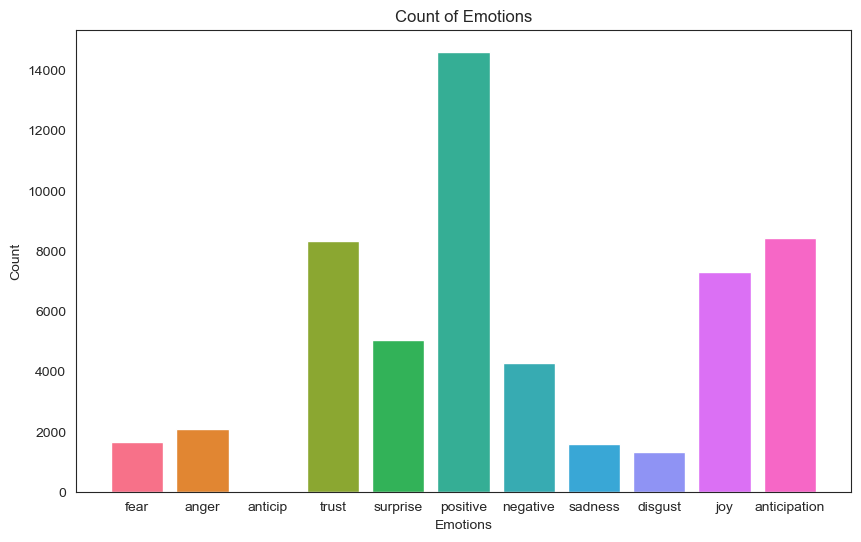

In [38]:
# NRC Emotion Lexicon
# Analyze sentiments and emotions using NRClex
sentiments = []

for review in review_df['feedback']:
    emotion_analyzer = NRCLex(review)
    emotions = emotion_analyzer.affect_frequencies
    sentiments.append(emotions)

# Create a new DataFrame with sentiment information
sentiments_df = pd.DataFrame(sentiments)

# Combine with the original DataFrame
result_df = pd.concat([reviews, sentiments_df], axis=1)
exclude_columns = ['feedback']  
# Get the columns to include in the X-axis 
x_columns = [col for col in result_df.columns if col not in exclude_columns]

palette = sns.color_palette("husl", len(x_columns))
# Create a bar plot with a colorful palette
plt.figure(figsize=(10, 6))
plt.bar(x_columns, result_df[x_columns].sum(), color=palette)
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Count of Emotions')
plt.show()


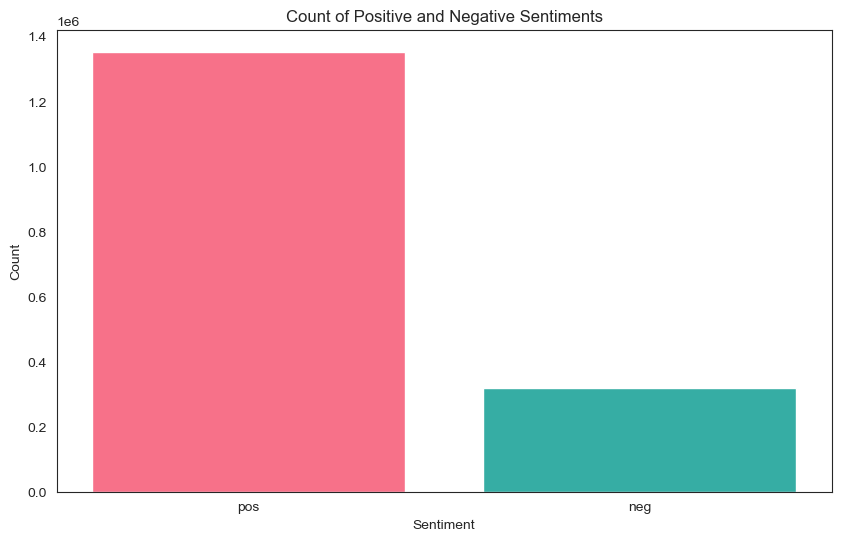

In [39]:
# SentiWordNet lexicon
# Analyze sentiments using SentiWordNet
sentiments = []

for review in review_df['feedback']:
    sentiment_scores = {'pos': 0, 'neg': 0}
    
    for word in review.split():
        synsets = list(swn.senti_synsets(word))
        
        for synset in synsets:
            sentiment_scores['pos'] += synset.pos_score()
            sentiment_scores['neg'] += synset.neg_score()

    sentiments.append(sentiment_scores)

# Create a new DataFrame with sentiment information
sentiments_df = pd.DataFrame(sentiments)

# Combine with the original DataFrame
result_df = pd.concat([reviews, sentiments_df], axis=1)

exclude_columns = ['feedback']  
# Get the columns to include in the X-axis 
x_columns = [col for col in result_df.columns if col not in exclude_columns]

# Create a colorful palette
palette = sns.color_palette("husl", len(x_columns))

# Create a bar plot with a colorful palette
plt.figure(figsize=(10, 6))
plt.bar(x_columns, result_df[x_columns].sum(), color=palette)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of Positive and Negative Sentiments')
plt.show()


<h3 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Topic Modelling of Product Names
            </span>   
        </font>    
</h3>

In [40]:
stop_words = set(stopwords.words('english'))
stop_words = list(stop_words)
stop_words1 = ['placeholder_for_any_customize_words'] + stop_words
def preprocess(text):
    text = re.sub(r'\b\d+\b', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.lower()  # Convert to lowercase
    text = [word for word in text.split() if word not in stop_words1]  # Remove stopwords
    return ' '.join(text)

flipkart_df['preprocessed_names'] = flipkart_df['ProductName'].apply(preprocess)

# Vectorization
vectorizer = CountVectorizer(ngram_range = (1,1), max_features=1000, max_df=0.5)

X = vectorizer.fit_transform(flipkart_df['preprocessed_names'])

# LDA Model - This is used for Topic Modeling popularly 
number_of_topics = 76
lda = LatentDirichletAllocation(n_components=number_of_topics, random_state=24)
lda.fit(X)

# Display topics and top words for each topic
feature_names = vectorizer.get_feature_names_out() # Get all the features/tokens names in vectorized data

num_words = 10        

for idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[-num_words:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {idx+1}: {', '.join(top_words)}")

Topic 1: light, outdoor, led, flood, party, car, men, comfort, trendy, sneakers
Topic 2: birthday, foil, happy, balloon, decoration, 5â, size, football, balloons, balloonâ
Topic 3: grinder, mixer, butterfly, plus, juicer, rapid, wet, bajaj, gx1, rhino
Topic 4: 1080p, store, security, hd, steel, system, cctv, alarm, collapsible, carbon
Topic 5: sportsoul, supportâ, cotton, gym, athletic, abdomen, mimo, mu, gigabit, mbps
Topic 6: wrist, hard, external, tb, drive, disk, years, fitness, victory, professional
Topic 7: sine, inverter, wave, star, samsung, pure, free, double, refrigeratorâ, frost
Topic 8: thomson, alpha, cm, manure, cow, plant, home, potting, kg, natural
Topic 9: mobile, holder, tanunni, helicopter, control, remote, flipkart, mayne, charging, engineered
Topic 10: plus, samsung, gb, memory, evo, cardâ, class, mb, microsdxc, iron
Topic 11: poco, c31, pure, inverter, wave, microtek, manure, sine, dry, powder
Topic 12: cooker, smartbuy, electric, flipkart, rice, media, streaming,

In [42]:
# Assigning Products to Generated Topics
unique_product_names_list = flipkart_df['ProductName'].unique().tolist()

product_topic_mapping = {}

# Transform each product name into a topic using the trained LDA model
for product_name in unique_product_names_list:
    # Preprocess the product name
    preprocessed_product = preprocess(product_name)
    
    # Vectorize the preprocessed product name
    product_vector = vectorizer.transform([preprocessed_product])
    
    # Get the topic probabilities for the product
    topic_probabilities = lda.transform(product_vector)
    
    # Find the topic with the highest probability for this product
    assigned_topic = np.argmax(topic_probabilities)
    
    # Store the product-to-topic mapping in the dictionary
    product_topic_mapping[product_name] = assigned_topic

# Example: Print the product and its assigned topic for the first 10 products
for product, topic in list(product_topic_mapping.items())[:10]:
    print(f"Product: {product} | Assigned Topic: {topic}")


Product: Candes 12 L Room/Personal Air Cooler | Assigned Topic: 60
Product: Candes 60 L Room/Personal Air Cooler | Assigned Topic: 60
Product: MAHARAJA WHITELINE 65 L Desert Air Cooler | Assigned Topic: 55
Product: Crompton 75 L Desert Air Cooler | Assigned Topic: 60
Product: colcum Collapsible Wardrobe 88130 Micro Fiber Collapsible WardrobeÂ Â  | Assigned Topic: 71
Product: FLIPZON Baby 6 Shelve Unbreakable Material PVC Collapsible WardrobeÂ Â  | Assigned Topic: 71
Product: S . K Store Carbon Steel Collapsible WardrobeÂ Â  | Assigned Topic: 3
Product: Furnifry Wooden TV Entertainment Unit/Wall Set Top Box Shelf Stand/TV Unit Bedroom/ Engineered Wood TV Entertainment UnitÂ Â  | Assigned Topic: 52
Product: Zofiy 6 Layer Metal Frame Clothes Organizer - Maroon PP Collapsible WardrobeÂ Â  | Assigned Topic: 39
Product: POOWEREST Carbon Steel Collapsible WardrobeÂ Â  | Assigned Topic: 3


In [41]:
# Deployment
lda_path = "lda_sklearn.pkl"
vectorizer_path = "vectorizer.pkl"

def save_model(lda, lda_path, vect, vect_path):
    pickle.dump(lda, open(lda_path, 'wb')) # wb - write in a binary form 
    pickle.dump(vect, open(vect_path, 'wb'))
    
save_model(lda, lda_path, vectorizer, vectorizer_path)

lda = pickle.load(open("lda_sklearn.pkl", 'rb'))
vectorizer = pickle.load(open("vectorizer.pkl", 'rb'))

example = "birthday gift"

def identify_topic(lda, vect, example):
    vectorized = vect.transform([example])
    topic = lda.transform(vectorized)
    print(topic)
    return topic

identify_topic(lda, vectorizer, example)

# Result is an array of probabilities, one for each topic. Find the largest probability and that is the topic

[[0.00438596 0.31250473 0.00438596 0.00438596 0.00438596 0.00438596
  0.00438596 0.00438596 0.00438596 0.00438596 0.00438596 0.00438596
  0.00438596 0.00438596 0.00438596 0.00438596 0.00438596 0.00438596
  0.00438596 0.00438596 0.00438596 0.00438596 0.00438596 0.00438596
  0.00438596 0.00438596 0.00438596 0.00438596 0.00438596 0.00438596
  0.00438596 0.00438596 0.00438596 0.00438596 0.00438596 0.00438596
  0.00438596 0.00438596 0.00438596 0.00438596 0.00438596 0.36293386
  0.00438596 0.00438596 0.00438596 0.00438596 0.00438596 0.00438596
  0.00438596 0.00438596 0.00438596 0.00438596 0.00438596 0.00438596
  0.00438596 0.00438596 0.00438596 0.00438596 0.00438596 0.00438596
  0.00438596 0.00438596 0.00438596 0.00438596 0.00438596 0.00438596
  0.00438596 0.00438596 0.00438596 0.00438596 0.00438596 0.00438596
  0.00438596 0.00438596 0.00438596 0.00438596]]


array([[0.00438596, 0.31250473, 0.00438596, 0.00438596, 0.00438596,
        0.00438596, 0.00438596, 0.00438596, 0.00438596, 0.00438596,
        0.00438596, 0.00438596, 0.00438596, 0.00438596, 0.00438596,
        0.00438596, 0.00438596, 0.00438596, 0.00438596, 0.00438596,
        0.00438596, 0.00438596, 0.00438596, 0.00438596, 0.00438596,
        0.00438596, 0.00438596, 0.00438596, 0.00438596, 0.00438596,
        0.00438596, 0.00438596, 0.00438596, 0.00438596, 0.00438596,
        0.00438596, 0.00438596, 0.00438596, 0.00438596, 0.00438596,
        0.00438596, 0.36293386, 0.00438596, 0.00438596, 0.00438596,
        0.00438596, 0.00438596, 0.00438596, 0.00438596, 0.00438596,
        0.00438596, 0.00438596, 0.00438596, 0.00438596, 0.00438596,
        0.00438596, 0.00438596, 0.00438596, 0.00438596, 0.00438596,
        0.00438596, 0.00438596, 0.00438596, 0.00438596, 0.00438596,
        0.00438596, 0.00438596, 0.00438596, 0.00438596, 0.00438596,
        0.00438596, 0.00438596, 0.00438596, 0.00

<h3 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Creating & Deploying the Search Functionality
            </span>   
        </font>    
</h3>

In [44]:
def search_products_by_query(query, num_results=5):
    # Preprocess the user query
    preprocessed_query = preprocess(query)
    # Vectorize the preprocessed query
    query_vector = vectorizer.transform([preprocessed_query])
    # Get the topic probabilities for the query
    query_topic_probabilities = lda.transform(query_vector)
    # Find the most relevant topic for the query
    relevant_topic = np.argmax(query_topic_probabilities)
    # Initialize a list to store relevant product names
    relevant_products = []
    # Iterate through the product-topic mapping to find products in the relevant topic
    for product, topic in product_topic_mapping.items():
        if topic == relevant_topic:
            relevant_products.append(product)
    # Return the top num_results relevant product names
    return relevant_products[:num_results]

# UBCF and IBCF
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / (1 + np.array([np.abs(similarity).sum(axis=1)]))
    return pred

user_similarity = cosine_similarity(train_user_item)
item_similarity = cosine_similarity(train_user_item.T)

ubcf_predictions = predict(train_user_item, user_similarity, type='user')
ibcf_predictions = predict(train_user_item, item_similarity, type='item')

# Function to get associated products for a given product
def get_associated_products(product_name):
    associated_products = []
    for index, row in filtered_rules.iterrows():
        antecedents = list(row['antecedents'])
        consequents = list(row['consequents'])
        
        if product_name in antecedents:
            associated_products.extend(consequents)
    
    return list(set(associated_products))

# Function to recommend products based on UBCF for a specific user
def recommend_ubcf_products(user_id, user_item_matrix, ubcf_preds, K):
    recos = {'ProductName': [], 'Rating': []}
    
    # Find the index corresponding to the user ID
    user_index = user_item_matrix.index.get_loc(user_id)
    
    user_array = ubcf_preds[user_index]
    orig_ratings = user_item_matrix.loc[user_id]

    for product_id in range(len(orig_ratings)):
        if orig_ratings[product_id] == 0:
            recos['ProductName'].append(user_item_matrix.columns[product_id])
            recos['Rating'].append(user_array[product_id])

    recos_df = pd.DataFrame(recos)
    recommend_df = recos_df.sort_values(by='Rating', ascending=False).head(K)

    return recommend_df

# Function to recommend products based on IBCF for a specific user
def recommend_ibcf_products(user_id, user_item_matrix, ibcf_preds, K):
    recos = {'ProductName': [], 'Rating': []}
    
    # Find the index corresponding to the user ID
    user_index = user_item_matrix.index.get_loc(user_id)
    
    user_array = ibcf_preds[user_index]
    orig_ratings = user_item_matrix.loc[user_id]

    for product_id in range(len(orig_ratings)):
        if orig_ratings[product_id] == 0:
            recos['ProductName'].append(user_item_matrix.columns[product_id])
            recos['Rating'].append(user_array[product_id])

    recos_df = pd.DataFrame(recos)
    recommend_df = recos_df.sort_values(by='Rating', ascending=False).head(K)

    return recommend_df

# Create a GUI window
app = tk.Tk()
app.title("Product Search and Recommendations")

# Function to search for products and display associated recommendations
def search_and_recommend():
    query = entry.get()  # Get the user's query from the input field
    relevant_products = search_products_by_query(query)
    
    result_text.config(state=tk.NORMAL)  # Enable text widget for editing
    result_text.delete('1.0', tk.END)    # Clear previous results
    
    if relevant_products:
        result_text.insert(tk.END, "Top 5 Relevant Products in the Same Topic:\n")
        for i, product in enumerate(relevant_products, start=1):
            result_text.insert(tk.END, f"{i}. {product}\n")
        
        # Separate sections with a line
        result_text.insert(tk.END, "_____________________________________________________________________\n")

        # Recommend products based on UBCF
        user_id = "FLP20IND1924"  # Replace with the actual user ID
        top_k_ubcf_recommendations = 5  # Replace with the number of top UBCF recommendations you want
        ubcf_recommendations = recommend_ubcf_products(user_id, test_user_item, ubcf_predictions, top_k_ubcf_recommendations)
        result_text.insert(tk.END, "Recommendation based on similar users as yours:\n")
        for i, product in enumerate(ubcf_recommendations['ProductName'], start=1):
            result_text.insert(tk.END, f"{i}. {product}\n")
        
        # Separate sections with a line
        result_text.insert(tk.END, "_____________________________________________________________________\n")

        # Recommend products based on IBCF
        top_k_ibcf_recommendations = 5  # Replace with the number of top IBCF recommendations you want
        ibcf_recommendations = recommend_ibcf_products(user_id, test_user_item, ibcf_predictions, top_k_ibcf_recommendations)
        result_text.insert(tk.END, "Recommendation based on similar products as yours:\n")
        for i, product in enumerate(ibcf_recommendations['ProductName'], start=1):
            result_text.insert(tk.END, f"{i}. {product}\n")

        # Separate sections with a line
        result_text.insert(tk.END, "_____________________________________________________________________\n")

        # Display associated products for the top 3 search results below the recommendation section
        result_text.insert(tk.END, "Associated Products for Top 3 Search Results:\n")
        for i, product in enumerate(relevant_products[:3], start=1):
            associated_products = get_associated_products(product)
            result_text.insert(tk.END, f"Search Result {i}: {', '.join(associated_products)}\n\n")

    else:
        result_text.insert(tk.END, "No relevant products found for the query.")
    
    result_text.config(state=tk.DISABLED)  # Disable text widget for editing

# Create and pack a label
label = tk.Label(app, text="Enter your query:")
label.pack()

# Create and pack an entry field for user input
entry = tk.Entry(app)
entry.pack()

# Create and pack a search button
search_button = tk.Button(app, text="Search and Recommend", command=search_and_recommend)
search_button.pack()

# Create a text widget to display results
result_text = tk.Text(app, height=80, width=150)
result_text.pack()
result_text.config(state=tk.DISABLED)  # Disable text widget for editing

# Run the GUI application
app.mainloop()